

## **Deep Learning in Biomedicine**
#### **Final Project:** Classification of Chest X-ray Images and Patient Metadata Using Multi-Modal Model
**Team 4**: Alexander Sternfeld, Silvia Romanato and Antoine Bonnet


Here is a table with the models we will train:
| Model | Vision | Tabular |
| --- | --- | --- |
| 1 | - | FCN | 
| 2 | ResNet50 (CNN) | FCN | 
| 3 | ResNet50 (CNN) | - |
| 4 | DenseNet (CNN) | FCN | 
| 5 | DenseNet (CNN) | - | 
| 6 | Vision Transformer (ViT) | FCN | 
| 7 | Vision Transformer (ViT)| - | 

We use the same fully-connected network (FCN) for all models. 

### **Some ideas for the encoders**

https://github.com/naity/image_tabular 

<img src="../figures/joint_encoders.png" alt="drawing" width="800"/>



In [1]:
from data import *
from utils import *
from models import *

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torchvision.models import densenet121, DenseNet121_Weights, ResNet50_Weights, resnet50

%load_ext autoreload
%autoreload 2

## 1: **Data**

In [5]:
# Info from the images
info_jpg = pd.read_csv('../real_data/mimic-cxr-2.0.0-metadata.csv')
info_jpg.head(1)

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,CHEST (PA AND LAT),postero-anterior,Erect


In [6]:
labels_data = pd.read_csv('../real_data/mimic-cxr-2.0.0-chexpert.csv')
labels_data.head(1)

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


## 2. **Visual Encoders**



In [7]:
# The data are unbalanced, therefore we need to implement a weighted sample or the weighted loss function:

# from torch.utils.data import WeightedRandomSampler

# # Calculate weights for each sample
# weights = 1. / torch.tensor([class_counts[label] for label in labels], dtype=torch.float)
# sampler = WeightedRandomSampler(weights, len(weights))

# # Use this sampler in the DataLoader
# dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)


######### We are trying to perform the weighted loss function first #########

In [9]:
image_files = list_images('../real_data/files')
image_labels_mapping = create_image_labels_mapping(image_files, labels_data, info_jpg)
df = pd.DataFrame.from_dict(image_labels_mapping, orient='index').reset_index()
df['dicom_id'] = df['index'].apply(lambda x: x.split('/')[-1].split('.')[0])
split = pd.read_csv('../real_data/mimic-cxr-2.0.0-split.csv')

# merge the two dataframes on subject_id and study_id
df = pd.merge(df, split, on=['subject_id', 'study_id', 'dicom_id'], how = 'left')

In [10]:
# create the train and test dataframes
train_df = df[df['split'] == 'train']
train_paths = train_df['index'].tolist()
train_labels = train_df.iloc[:, 1:15].values.tolist()
train_dict = create_image_labels_mapping(image_files, labels_data, info_jpg)

In [11]:
test_df = df[df['split'] == 'test']
test_paths = test_df['index'].tolist()
test_labels = test_df.iloc[:, 1:15].values.tolist()
test_dict = create_image_labels_mapping(image_files, labels_data, info_jpg)

### 2.1. **ResNet** (CNN)

In [12]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),                                               # Resize images to the size expected by ResNet
    transforms.ToTensor(),                                                       # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

train_dataset = MedicalImagesDataset(train_dict, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)  
test_dataset = MedicalImagesDataset(test_dict, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Iterate over batches of image,label pairs
for i, (pa_images, lateral_images, labels) in enumerate(train_dataset):
    print('Posterior Anterior view: ', pa_images.shape)
    print('Lateral view', lateral_images.shape)
    break

Posterior Anterior view:  torch.Size([3, 256, 256])
Lateral view torch.Size([3, 256, 256])


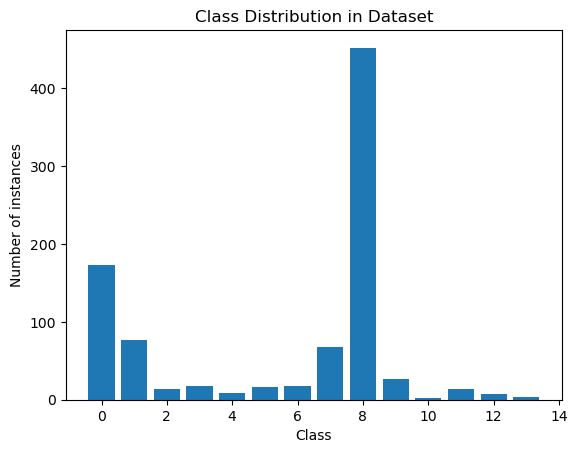

In [13]:
import torch
from collections import Counter
import matplotlib.pyplot as plt

# class_counts = Counter()
# for _, _, labels in dataloader:
#     labels = torch.argmax(labels, dim=1)
#     class_counts.update(labels.tolist())
# print(class_counts)

class_counts = {8: 452, 0: 173, 1: 77, 7: 68, 9: 27, 6: 17, 3: 17, 
                5: 16, 11: 14, 2: 14, 4: 9, 12: 7, 13: 3, 10: 2}

# Plot the class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of instances')
plt.title('Class Distribution in Dataset')
plt.show()

By this distrbution we can see that the data is imbalanced. We will use the `class_weight` on the cross-entropy loss to account for this. <br>
Other possibilities are: 
1. **Resampling Your Dataset**:
Oversampling the Minority Class: Increase the number of instances of underrepresented classes in your training set. This can be done by duplicating existing instances or generating synthetic instances (e.g., using SMOTE).
Undersampling the Majority Class: Reduce the number of instances of overrepresented classes.
2. **Data Augmentation**:
Apply data augmentation techniques to the minority class to create synthetic data points. This is especially useful in image and audio processing tasks.
3. **Change the Evaluation Metric**:
Use evaluation metrics like F1-score, precision-recall curve, ROC AUC, etc., which give a better sense of model performance on imbalanced datasets.

In [14]:
class_counts = {8: 452, 0: 173, 1: 77, 7: 68, 9: 27, 6: 17, 3: 17, 
                5: 16, 11: 14, 2: 14, 4: 9, 12: 7, 13: 3, 10: 2}
class_weights = 1. / torch.tensor(list(class_counts.values()), dtype=torch.float)
print('The class weights are: ', class_weights)

model = DualInputModel(model='resnet50', num_classes=14)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

The class weights are:  tensor([0.0022, 0.0058, 0.0130, 0.0147, 0.0370, 0.0588, 0.0588, 0.0625, 0.0714,
        0.0714, 0.1111, 0.1429, 0.3333, 0.5000])


In [ ]:
import torch

num_epochs = 2
verbose = False

def train_model(model, num_epochs, train_dataloader, criterion, optimizer, device, verbose = False):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for i, (x_pa, x_lateral, labels) in enumerate(train_dataloader):
            # Forward pass
            inputs = x_lateral.to(device), x_pa.to(device)
            outputs = model(inputs[0], inputs[1])
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)
            if verbose:
                print('Predicted: ', predicted, 'Labels: ', labels, 'Loss: ', loss.item())
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(train_dataloader)
        epoch_accuracy = 100 * correct_predictions / total_predictions

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    return model

def test_model(model, test_dataloader, device):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for i, (x_pa, x_lateral, labels) in enumerate(test_dataloader):
            inputs = x_lateral.to(device), x_pa.to(device)
            labels = labels.to(device)
            outputs = model(inputs[0], inputs[1])
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        test_accuracy = 100 * correct_predictions / total_predictions
        print(f'Test Accuracy: {test_accuracy:.2f}%')
    
    return test_accuracy, model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_model(model, num_epochs, train_dataloader, criterion, optimizer, device, verbose = False)
model = test_model(model, test_dataloader, device)
torch.save(model.state_dict(), 'model.pth')

### 2.2. **DenseNet** (CNN)

[GitHub link](https://github.com/liuzhuang13/DenseNet)

[Huggingface link](https://huggingface.co/docs/timm/models/densenet)

In [ ]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),                                               # Resize images to the size expected by ResNet
    transforms.ToTensor(),                                                       # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

train_dataset = MedicalImagesDataset(train_dict, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)  
test_dataset = MedicalImagesDataset(test_dict, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Iterate over batches of image,label pairs
# for i, (pa_images, lateral_images, labels) in enumerate(train_dataset):
#     print('Posterior Anterior view: ', pa_images.shape)
#     print('Lateral view', lateral_images.shape)
#     break

The input of the images is 224x224x3 times 2 (frontal and lateral images). <br>
The input of the labels is 1x14 features, with binary values (0 or 1). These are categorical features. <br>
The output of the model is 1x14 features, with binary values (0 or 1). <br>



In [ ]:
num_epochs = 2

class_counts = {8: 452, 0: 173, 1: 77, 7: 68, 9: 27, 6: 17, 3: 17, 
                5: 16, 11: 14, 2: 14, 4: 9, 12: 7, 13: 3, 10: 2}
class_weights = 1. / torch.tensor(list(class_counts.values()), dtype=torch.float)
print('The class weights are: ', class_weights)

model = DualInputModel(model='densenet121', num_classes=14)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model(model, num_epochs, train_dataloader, criterion, optimizer, device, verbose = False)
test_model(model, test_dataloader, device)
torch.save(model.state_dict(), 'model.pth')

The class weights are:  tensor([0.0022, 0.0058, 0.0130, 0.0147, 0.0370, 0.0588, 0.0588, 0.0625, 0.0714,
        0.0714, 0.1111, 0.1429, 0.3333, 0.5000])


TypeError: train_model() got an unexpected keyword argument 'verbose'

### 2.3. **Vision Transformer** (ViT)

In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])